## 1.0 Introduction

The main objective of this feature is to create checkpoints in a series of functions to facilitate the debugging process and restart the execution after the last successfully executed point in the series. Enjoy!!


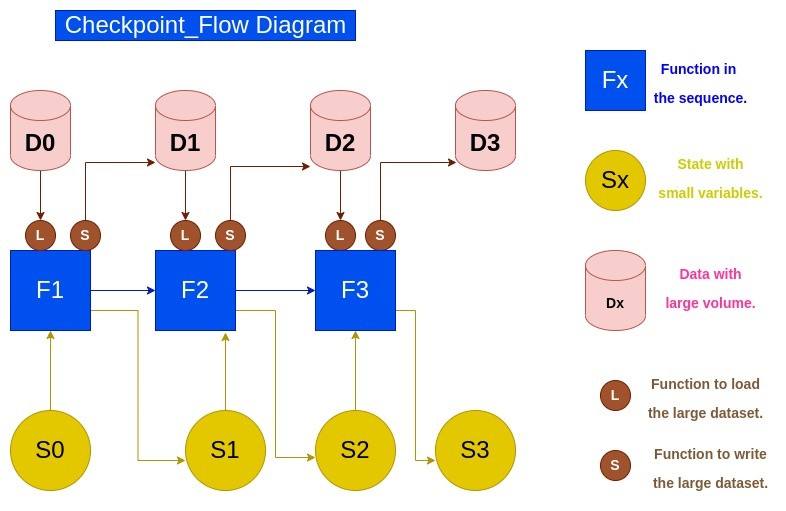

In the diagram, we have 3 functions ($F_{1}$, $F_{2}$ and $F_{3}$) to be executed in sequence (i.e. linearly). Each function can access small variables or large data, represented by the yellow circles $S_{x}$ and the pink cilinders $D_{x}$, respectively. The small variables $S_{x}$ are also referenced as the state of the execution, given to each function. Any function can read it and even modified it as it goes. The state is saved after every function finishes by a specific class with this purpose. There's already a default class for it, called `LocalStateHandler`, which can save the state to a local file and read it from there as well.

The functions can read, modify and write the large volumes of data as necessary in different sources, even, since this responsability lies with the functions represented by the small brown circles ($L$ are the loading functions, they load the data into memory; and $S$ are the saving functions, which save the data in the proper place).

This architecture allows for a more flexible configuration. So for instance, not all functions need to load or save heavy datasets, also, each one can do it in very different ways, saving different sets, in different places.

If the code breaks, let's say, in function $F_{2}$, then you can find the error, fix it, and when the program is executed again, function $F_{1}$, which already executed without errors doesn't need to be run again, and so, the execution restarts at $F_{2}$, loading the exactly state as left by $F_{1}$ and the exact heavy data it needs.

## 1.1 Import modules

In [1]:
from gumly.checkpoint_flow import CheckpointFlow

## 1.2 Telling a story

Imagine you are writing three code procedures to run, all of them are heavy and take some time to run. They might load large amounts of data and write them down as well.

### Step 1 -  Calling the Class CheckpointFlow

In [2]:
cp = CheckpointFlow("checkpoint.pkl", handler='local')

###  step 2 - Create the inicial state

#### We have some initial variables values that are necessary for the first procedure:

In [3]:
initial_state = dict(a='value of A')

### Step - 3 Starting the function loader and Save

We write the code to load and save the large datasets separetely.

In [4]:
def loader(state):
    print("loader")
    return {'x': [1, 2, 3]}

def saver(state, data):
    print(f"saver printing data={data}")
    
def loader3(state):
    print("loader3")
    return {'z': ['A', 'B', 'C']}

def saver3(state, data):
    print(f"saver3 printing data={data}")

### Step 4 - Wrap and add the decorator

These are the procedures, which are wraped and added to the sequence of the flow with the decorator `add_step`:

In [5]:
@cp.add_step(load=loader, save=saver)
def f1(state, data):
    print(f"f1 printing state: {state}")
    print(f"f1 printing data: {data}")
    state['d'] = 'D'

@cp.add_step()
def f2(state, data):
    raise Exception("This thing broke!")

@cp.add_step(load=loader3, save=saver3)
def f3(state, data):
    print(f"f3 printing state: {state}")
    print(f"f3 printing data: {data}")
    state['c'] = 4.5

### Step 5 - Execute with Checkpoint Flow

In [6]:
cp.run(initial_state)

loader
f1 printing state: {'a': 'value of A'}
f1 printing data: {'x': [1, 2, 3]}
saver printing data={'x': [1, 2, 3]}


Exception: This thing broke!

Look!!! Some function broke let's fix it now.  

### Step 6 - Fix and Run Again. 

In [7]:
# we are reinstantiating the object, because we are simulating a rerun of the full code
cp = CheckpointFlow("checkpoint.pkl", handler='local')

@cp.add_step(load=loader, save=saver)
def f1(state, data):
    print(f"f1 printing state: {state}")
    print(f"f1 printing data: {data}")
    state['d'] = 'D'

# the fixed function
@cp.add_step()
def f2(state, data):
    print(f"f2 printing state: {state}")
    print(f"f2 printing data: {data}")

@cp.add_step(load=loader3, save=saver3)
def f3(state, data):
    print(f"f3 printing state: {state}")
    print(f"f3 printing data: {data}")
    state['c'] = 4.5

#### Now, let's run everything again:

In [8]:
cp.run(initial_state)

f2 printing state: {'a': 'value of A', 'd': 'D', 'checkpoint_index': 1}
f2 printing data: {}
f3 printing state: {'a': 'value of A', 'd': 'D', 'checkpoint_index': 2}
f3 printing data: {}
saver3 printing data={}


Notice that the code started from `f2`, instead of `f1` this time. If we run it again, it will start from the beggining, this is the magic of this feature!!!!

### Optional Modes
If we want to run every loading function, we can set it in the loading policy with the value `"always"`, otherwise, it will execute only the first loading function.

In [10]:
cp.run(initial_state, load_policy='always')

loader
f1 printing state: {'a': 'value of A', 'd': 'D', 'checkpoint_index': 0, 'c': 4.5}
f1 printing data: {'x': [1, 2, 3]}
saver printing data={'x': [1, 2, 3]}
f2 printing state: {'a': 'value of A', 'd': 'D', 'checkpoint_index': 1, 'c': 4.5}
f2 printing data: {'x': [1, 2, 3]}
loader3
f3 printing state: {'a': 'value of A', 'd': 'D', 'checkpoint_index': 2, 'c': 4.5}
f3 printing data: {'x': [1, 2, 3], 'z': ['A', 'B', 'C']}
saver3 printing data={'x': [1, 2, 3], 'z': ['A', 'B', 'C']}


If we want to start from a specfic point, even if nothing broke, we just need to pass the checkpoint index to the `run` method.

REMEMBER: The index starts at `0`:

In [11]:
cp.run(initial_state, checkpoint=1)

f2 printing state: {'a': 'value of A', 'd': 'D', 'checkpoint_index': 0, 'c': 4.5}
f2 printing data: {}
f3 printing state: {'a': 'value of A', 'd': 'D', 'checkpoint_index': 2, 'c': 4.5}
f3 printing data: {}
saver3 printing data={}


## 2.0 Conclusion and library advantages

This feature shines when you have different procedures which can take a long time due to large data processing and you are in the experimentation phase of the project, so you are not using an orchestrator yet. So you can write it as different functions and if it breaks in the middle, you don't have to wait for every successful function to be run again. Plus, you can inspect the initial state of any broken function. Good luck! 